# LGSSM Demo - Random Walk

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import NamedTuple
from jax.random import multivariate_normal, split
from tqdm.notebook import tqdm, trange
from jax.random import multivariate_normal
from tensorflow_probability.substrates import jax as tfp
from jaxkf._src.functional.filter import kalman_step, filter_step_sequential, forward_filter
tfd = tfp.distributions
import jaxkf._src.lgssm as lgssm
from jaxkf._src.types import StatePrior, State, KFParams, KFParamsDist
from jaxkf._src.models.kalmanfilter import init_kf_params


import matplotlib.pyplot as plt

In [3]:
# from chex import dataclass
from dataclasses import dataclass

## Data

---
Like before, we can describe the dynamical system like so:

$$
\begin{aligned}
\mathbf{z}_{t+1} &= \mathbf{F}\mathbf{z}_t + \boldsymbol{\epsilon}_\mathbf{z} \\
x_t &= \mathbf{H}\mathbf{z}_t + \boldsymbol{\epsilon}_x
\end{aligned}
$$

We can manually define the terms, $\mathbf{F}$ and $\mathbf{H}$, which represent the relationship between the variables. Here they will be

$$
\begin{aligned}
\mathbf{F} &=
\begin{bmatrix}
1 & 1 \\ 0 & 1
\end{bmatrix} \\
\mathbf{H} &=
\begin{bmatrix}
1 & 0 
\end{bmatrix}
\end{aligned}
$$

Here, we assume that the state system is as follows:

$$
\begin{aligned}
\frac{\partial z^1}{\partial t} &= z^1 + z^2 \\
\frac{\partial z^2}{\partial t} &= z^1
\end{aligned}
$$

and we assume that the observation is related like so:

$$
x = z^1
$$

So essentially, we have an augmented the state space dimension, $\mathbf{z} \in \mathbb{R}^2$, which is higher than the observation space, $x \in \mathbb{R}^1$. Our assumption here is that there are higher order dynamics at play behind the scenes. 


#### Parameters

$$
\boldsymbol{\theta} = \{ \mathbf{F}, \mathbf{Q}, \mathbf{H}, \mathbf{R} \}
$$

## Parameters

In [4]:
# state_dim = 2
# obs_dim = 1


# # init prior params
# prior_noise = 1.0
# mu0 = jnp.ones(state_dim)
# Sigma0 = prior_noise * jnp.ones(state_dim)

# # init transition params
# trans_noise = 1.0
# transition_matrix = jnp.array([[1., 1.], [0., 1.]])
# transition_noise = trans_noise * jnp.ones((state_dim)) 

# # init transition params
# obs_noise = 50.0
# observation_matrix = jnp.array([[1., 0.]])  
# observation_noise = obs_noise * jnp.ones((obs_dim))  

# # init params
# kf_params, kf_prior = init_kf_params(
#     mu0, 
#     Sigma0, 
#     transition_matrix, 
#     transition_noise,
#     observation_matrix,
#     observation_noise
# )

In [5]:
from jaxkf._src.data.univariate import make_noisy_signal_model

In [6]:
prior_noise = 1.0
trans_noise = 1.0
obs_noise = 50.0

kf_params_true, kf_prior_true = make_noisy_signal_model(
    trans_noise=trans_noise,
    obs_noise=obs_noise,
    prior_noise=prior_noise
)

### Samples

In [7]:
from jaxkf._src.functional.sample import sample_event

def gen_samples(
    kf_prior, 
    kf_params, 
    num_samples: int=20, 
    num_time_steps: int=10, 
    seed: int=123,
    sample_prior: bool=False
):
    

    state_samples, obs_samples = sample_event(
        kf_prior, 
        kf_params, 
        seed=seed, 
        sample_shape=(num_samples,), 
        num_time_steps=num_time_steps,
        sample_prior=sample_prior
    )
    
    return state_samples, obs_samples

In [8]:
# init samples params
num_samples = 100
num_time_steps = 50
seed = 123
sample_prior = False

# generate samples
state_samples, obs_samples = gen_samples(
    kf_prior_true, kf_params_true, 
    num_samples=num_samples, 
    num_time_steps=num_time_steps, 
    seed=seed, 
    sample_prior=sample_prior
)

# check shapes
assert state_samples.shape == (num_samples, num_time_steps, 2)
assert obs_samples.shape == (num_samples, num_time_steps, 1)

### Viz 

#### Sample State Trajectories

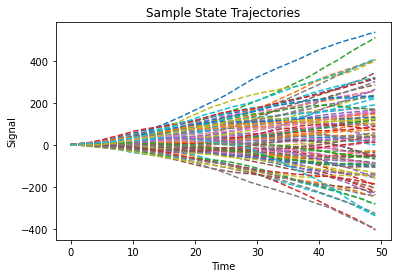

In [9]:
ts = jnp.arange(num_time_steps)

fig, ax = plt.subplots()

ax.plot(ts, state_samples[..., 0].T, linestyle="--")

ax.set(xlabel="Time", ylabel="Signal", title="Sample State Trajectories")

plt.show()

#### Samples + Observations

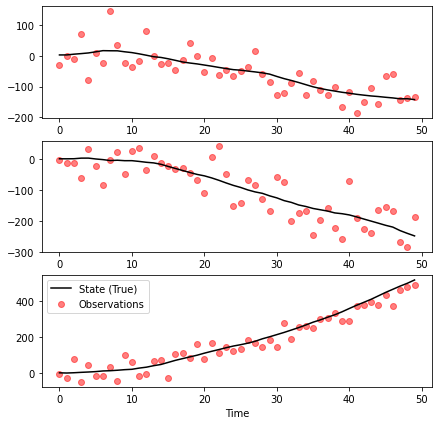

In [10]:


n_plots = 3

fig, axs = plt.subplots(nrows=n_plots, figsize=(7, 7))

for i, iax in enumerate(axs):
    

    iax.plot(ts, state_samples[i, ..., 0], label="State (True)", linestyle="-", color="black")
    iax.scatter(ts, obs_samples[i, ..., 0], color="red", label="Observations", alpha=0.5)
#     ax.set(xlabel="Time", ylabel="Signal")

iax.set(xlabel="Time")
plt.legend()
plt.show()

## Filtering

In [11]:
from jaxkf._src.functional.filter import forward_filter

In [12]:
# forward filter
state = forward_filter(obs_samples, kf_prior_true, kf_params_true)


assert state.mu_filtered.shape[0] == obs_samples.shape[0] 
assert state.Sigma_filtered.shape[0] == obs_samples.shape[0] 

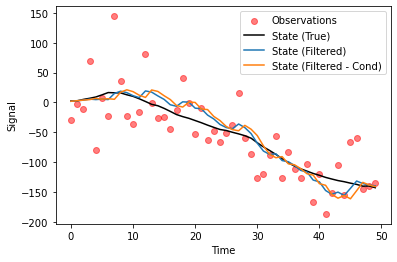

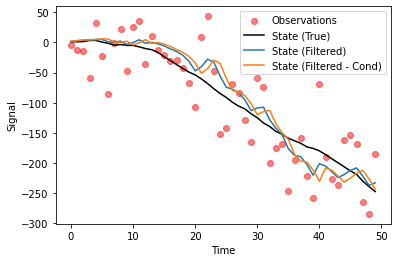

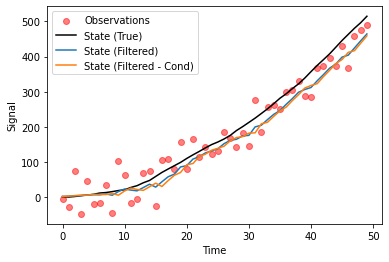

In [13]:
ts = jnp.arange(num_time_steps)

n_plots = 3

for batch_idx in jnp.arange(num_samples)[:n_plots]:
    fig, ax = plt.subplots()

    ax.scatter(ts, obs_samples[batch_idx, ..., 0], color="red", label="Observations", alpha=0.5)
    ax.plot(ts, state_samples[batch_idx, ..., 0], label="State (True)", linestyle="-", color="black")
    ax.plot(ts, state.mu_filtered[batch_idx, ..., 0], label="State (Filtered)", linestyle="-")
    ax.plot(ts, state.mu_cond[batch_idx, ..., 0], label="State (Filtered - Cond)", linestyle="-")
    ax.set(xlabel="Time", ylabel="Signal")

    plt.legend()
    plt.show()

## Model

In [14]:
import treex as tx
from jax.nn import softplus
from jaxkf._src.models.kalmanfilter import init_kf_params

### LGSSM

In [40]:
class LGSSM(tx.Module):
    # define free and fixed params
    # transition_matrix: jnp.ndarray = tx.Parameter.node()
    # transition_noise: jnp.ndarray = tx.Parameter.node()
    # emission_matrix: jnp.ndarray = tx.Parameter.node()
    emission_noise: jnp.ndarray = tx.Parameter.node()
    # prior_mean: jnp.ndarray = tx.Parameter.node()
    # prior_cov: jnp.ndarray = tx.Parameter.node()
    
    def __init__(self, prior, params):
        """
        Here we unpack the tupes
        """
        # init prior
        self.prior_mean = prior.mu0
        self.prior_cov = prior.Sigma0
        
        # init parameters
        self.transition_matrix = params.transition_matrix
        self.transition_noise = params.transition_noise
        self.emission_matrix = params.observation_matrix
        self.emission_noise = params.observation_noise
    
    def __call__(self, x):
        """Do filtering operation
        We pack up the tuples and push them through the filtering regime.
        """
        
        # constrain noise params
        
        # transition_noise = softplus(self.transition_noise)
        transition_noise = self.transition_noise
        emission_noise = softplus(self.emission_noise)
        # transition_matrix = softplus(self.transition_matrix)
        # emission_matrix = softplus(self.emission_matrix)
        # prior_cov = softplus(self.prior_cov)
        
        
        
        # init kf_params
        # print(self.prior_mean.shape, self.prior_cov.shape)
        # print(self.transition_matrix.shape, transition_noise.shape)
        # print(self.emission_matrix.shape, emission_noise.shape)
        kf_params, kf_prior = init_kf_params(
            mu0=self.prior_mean,
            Sigma0=self.prior_cov,
            transition_matrix=self.transition_matrix,
            transition_noise=transition_noise,
            observation_matrix=self.emission_matrix,
            observation_noise=emission_noise
        )
        

        state = forward_filter(x, kf_prior, kf_params)
                
        return state.mu_filtered, state.Sigma_filtered, state.log_likelihoods

#### Init Params

In [64]:
state_dim = 2
obs_dim = 1


# init prior params
prior_noise = 1.0
mu0 = jnp.zeros(state_dim)
Sigma0 = prior_noise * jnp.ones(state_dim)

# init transition params
trans_noise = 1.0
transition_matrix = jnp.array([[1., 1.], [0., 1.]])
# transition_matrix = jnp.array(np.random.randn(2,2))
# print(transition_matrix.shape)
transition_noise = trans_noise * jnp.ones((state_dim)) 

# init transition params
obs_noise = 10.0
observation_matrix = jnp.array([[1., 0.]])  
# observation_matrix = jnp.array(np.random.randn(1, 2))
observation_noise = obs_noise * jnp.ones((obs_dim))  

# init params
kf_params_init, kf_prior_init = init_kf_params(
    mu0, 
    Sigma0, 
    transition_matrix, 
    transition_noise,
    observation_matrix,
    observation_noise
)

In [65]:
# init model
lgssm_model = LGSSM(prior=kf_prior_init, params=kf_params_init).init(123)

# forward pass
mus, sigmas, log_probs = lgssm_model(obs_samples)

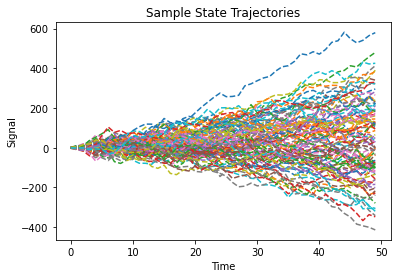

In [66]:
ts = jnp.arange(num_time_steps)

fig, ax = plt.subplots()

ax.plot(ts, mus[..., 0].T, linestyle="--")

ax.set(xlabel="Time", ylabel="Signal", title="Sample State Trajectories")

plt.show()

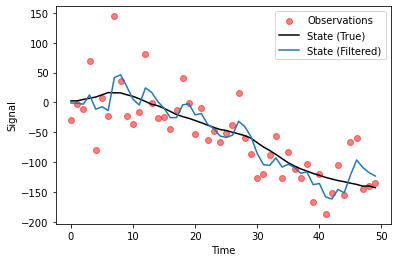

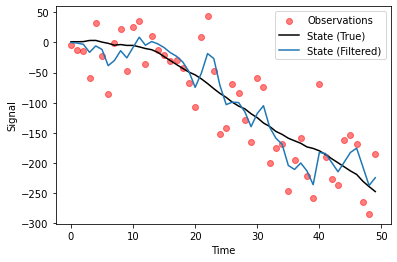

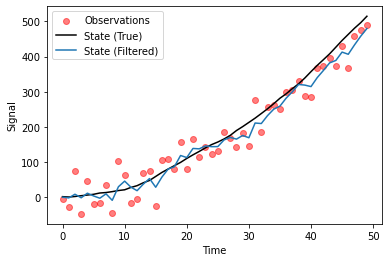

In [67]:
ts = jnp.arange(num_time_steps)

n_plots = 3

for batch_idx in jnp.arange(num_samples)[:n_plots]:
    fig, ax = plt.subplots()

    ax.scatter(ts, obs_samples[batch_idx, ..., 0], color="red", label="Observations", alpha=0.5)
    ax.plot(ts, state_samples[batch_idx, ..., 0], label="State (True)", linestyle="-", color="black")
    ax.plot(ts, mus[batch_idx, ..., 0], label="State (Filtered)", linestyle="-")
    ax.set(xlabel="Time", ylabel="Signal")

    plt.legend()
    plt.show()

In [68]:
# differentiate only w.r.t. parameters
def loss_fn(params, model, x):
    # merge params into model
    model = model.merge(params)

    # forward transformation
    *_, log_prob = model(x)
    
    log_prob = log_prob.sum(axis=1)
    
    # calculate nll
    loss = - jnp.mean(log_prob)

    # the model may contain state updates
    # so it should be returned
    return loss, model

In [69]:
# get model parsm
model_params = lgssm_model.parameters()

# 1 pass through function
loss, _ = loss_fn(model_params, lgssm_model, obs_samples)
loss

DeviceArray(392.31342, dtype=float32)

### Train Step

In [70]:
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

(loss_, m_), grads_ = grad_fn(model_params, lgssm_model, obs_samples)

In [71]:
loss_

DeviceArray(392.31342, dtype=float32)

In [72]:
grads_.emission_noise

DeviceArray([-24.489132], dtype=float32)

#### Optimizer

In [73]:
import optax

# init model
lgssm_model = LGSSM(prior=kf_prior_init, params=kf_params_init).init(123)

optimizer = tx.Optimizer(optax.adam(0.1)).init(lgssm_model)

### Train Step

In [74]:
# both model and optimizer are jit-able
@jax.jit
def train_step(model, x, optimizer):
    # select only the parameters
    params = model.parameters()

    (loss, model), grads = grad_fn(params, model, x)

    # update params and model
    params = optimizer.update(grads, params)
    model = model.merge(params)

    # return new model and optimizer
    return loss, model, optimizer

#### Training

In [75]:

from tqdm.notebook import trange, tqdm




n_iterations = 10_000
losses = []

train_data = obs_samples

with trange(n_iterations) as pbar:
    for i in pbar:
        
        loss, lgssm_model, optimizer = train_step(lgssm_model, train_data, optimizer)
        
        if i % 100 == 0:
            pbar.set_description(f"Loss: {loss:.4f}")
        losses.append(loss)

  0%|          | 0/10000 [00:00<?, ?it/s]

### Final Params

In [76]:
final_params = lgssm_model.parameters()

#### Transition Model

In [77]:
final_params.transition_matrix, kf_params_true.transition_matrix

(DeviceArray([[1., 1.],
              [0., 1.]], dtype=float32),
 DeviceArray([[1., 1.],
              [0., 1.]], dtype=float32))

In [78]:
softplus(final_params.transition_noise), kf_params_true.transition_noise

(DeviceArray([1.3132617, 1.3132617], dtype=float32),
 DeviceArray([1., 1.], dtype=float32))

#### Emission Model

In [79]:
final_params.emission_matrix, kf_params_true.observation_matrix

(DeviceArray([[1., 0.]], dtype=float32),
 DeviceArray([[1., 0.]], dtype=float32))

In [80]:
softplus(final_params.emission_noise), kf_params_true.observation_noise

(DeviceArray([38.3857], dtype=float32), DeviceArray([50.], dtype=float32))

#### Prior

In [81]:
final_params.prior_mean, kf_prior_true.mu0

(DeviceArray([0., 0.], dtype=float32), DeviceArray([1., 1.], dtype=float32))

In [82]:
softplus(final_params.prior_cov), kf_prior_true.Sigma0

(DeviceArray([1.3132617, 1.3132617], dtype=float32),
 DeviceArray([1., 1.], dtype=float32))

#### Viz - Losses

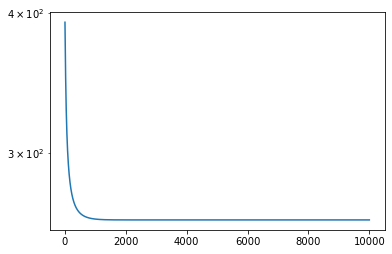

In [83]:
fig, ax = plt.subplots()

ax.plot(losses)
ax.set(yscale="log")
plt.show()

### Results

In [84]:
# forward pass
mus, sigmas, log_probs = lgssm_model(obs_samples)

#### Filtered

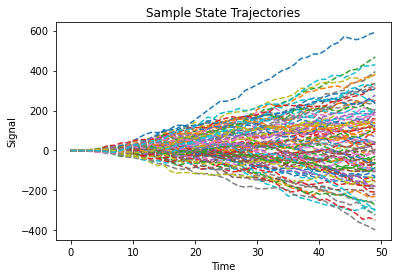

In [85]:
ts = jnp.arange(num_time_steps)

fig, ax = plt.subplots()

ax.plot(ts, mus[..., 0].T, linestyle="--")

ax.set(xlabel="Time", ylabel="Signal", title="Sample State Trajectories")

plt.show()

#### Samples

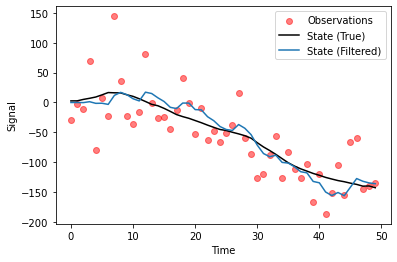

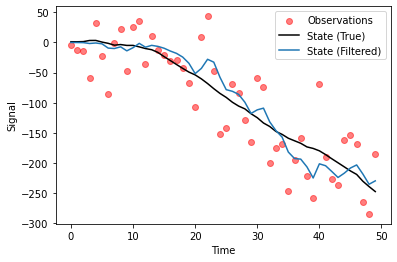

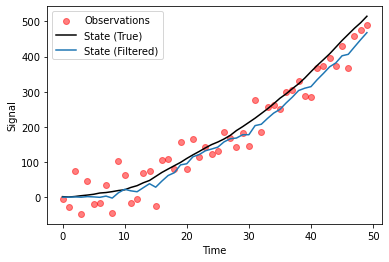

In [86]:
ts = jnp.arange(num_time_steps)

n_plots = 3

for batch_idx in jnp.arange(num_samples)[:n_plots]:
    fig, ax = plt.subplots()

    ax.scatter(ts, obs_samples[batch_idx, ..., 0], color="red", label="Observations", alpha=0.5)
    ax.plot(ts, state_samples[batch_idx, ..., 0], label="State (True)", linestyle="-", color="black")
    ax.plot(ts, mus[batch_idx, ..., 0], label="State (Filtered)", linestyle="-")
    ax.set(xlabel="Time", ylabel="Signal")

    plt.legend()
    plt.show()